# 1. Install Dependencies and Setup

In [22]:
%pip install tensorflow==2.12.0 opencv-python==4.7.0.72 matplotlib==3.7.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.3.3
fonttools                    4.39.3
gast                         0.4.0
google-auth                  2.17.2
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.53.0
h5py                         3.8.0
idna                         3.4
ipykernel                    6.22.0
ipython                      8.12.0
jax                          0.4.8
jedi 


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

- Avoid Ouf Of Memory (OOM) errors by setting GPU Memory Consumption Growth


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices("GPU")

[]

# 2. Remove dodgy images
- First when collecting images remove those which are smaller than 10 KB
- Check if images can be opened from opencv else remove them

In [60]:
data_dir = "data"
image_exts = ["jpeg","jpg", "bmp", "png"]
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e: 
            print(f"Issue with image {image_path}")
            os.remove(image_path)

# 3. Load Data

In [4]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 305 files belonging to 2 classes.


In [5]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch # tuple (image, label)

(array([[[[1.71000000e+02, 9.80000000e+01, 1.41000000e+02],
          [1.71000000e+02, 9.80000000e+01, 1.41000000e+02],
          [1.71625000e+02, 9.86250000e+01, 1.41625000e+02],
          ...,
          [2.14625000e+02, 1.44625000e+02, 1.32625000e+02],
          [2.14000000e+02, 1.44000000e+02, 1.32000000e+02],
          [2.13125000e+02, 1.43125000e+02, 1.31125000e+02]],
 
         [[1.71000000e+02, 9.80000000e+01, 1.41000000e+02],
          [1.71000000e+02, 9.80000000e+01, 1.41000000e+02],
          [1.71625000e+02, 9.86250000e+01, 1.41625000e+02],
          ...,
          [2.14905518e+02, 1.44905518e+02, 1.32905518e+02],
          [2.14280518e+02, 1.44280518e+02, 1.32280518e+02],
          [2.13779541e+02, 1.43779541e+02, 1.31779541e+02]],
 
         [[1.71000000e+02, 9.85800781e+01, 1.39839844e+02],
          [1.71000000e+02, 9.85800781e+01, 1.39839844e+02],
          [1.71625000e+02, 9.92050781e+01, 1.40464844e+02],
          ...,
          [2.15362549e+02, 1.45362549e+02, 1.3336

- Images as numpy array

In [6]:
batch[0].shape

(32, 256, 256, 3)

- Labels 0/1 corresponding to happy/sad

In [7]:
batch[1]

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1])

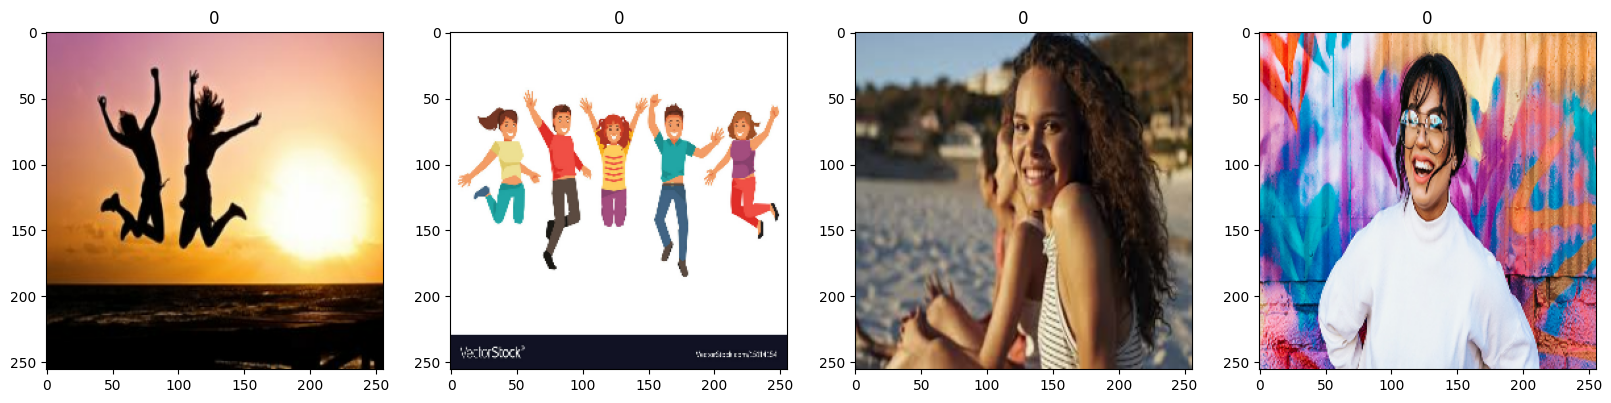

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data
- Scale data in pipeline. ML models train much better with small numbers between 0 to 1
- x: images 
- y: labels 

In [9]:
data = data.map(lambda x,y: (x/255, y))

In [10]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

# 5. Split Data

In [11]:
len(data) # numbers of batches

10

In [12]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [13]:
train_size

7

In [14]:
val_size

2

In [15]:
test_size

1

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model
- Using Sequential API from Keras which is great for one input and one output
- Functional API is more flexible

In [85]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [103]:
model = Sequential()

In [104]:
# 16 filters, 3x3, 1 pixel step 
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [105]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [106]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 16)      

# 7. Train

In [107]:
logdir='logs'

In [108]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [109]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 9s 920ms/step - loss: 1.0836 - accuracy: 0.5357 - val_loss: 0.7126 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 0.6913 - accuracy: 0.5536 - val_loss: 0.6694 - val_accuracy: 0.6094
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.6557 - accuracy: 0.5625 - val_loss: 0.5722 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.5963 - accuracy: 0.6473 - val_loss: 0.5497 - val_accuracy: 0.6094
Epoch 5/20
7/7 [==============================] - 12s 2s/step - loss: 0.5101 - accuracy: 0.7812 - val_loss: 0.6038 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.5128 - accuracy: 0.7500 - val_loss: 0.4808 - val_accuracy: 0.7969
Epoch 7/20
7/7 [==============================] - 12s 2s/step - loss: 0.4450 - accuracy: 0.8170 - val_loss: 0.4141 - val_accuracy: 0.8906
Epoch 8/20
7/7 [==================

# 8. Plot Performance

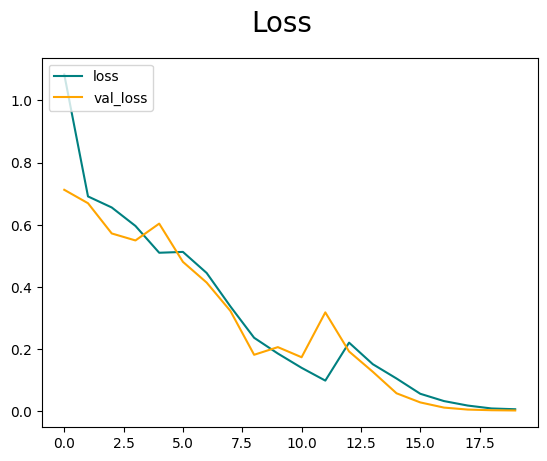

In [110]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

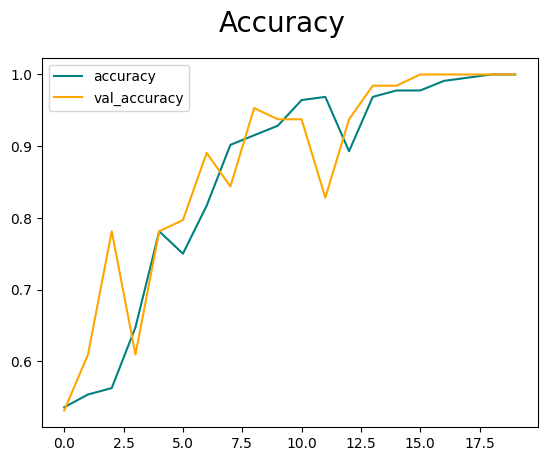

In [111]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [112]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [113]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 157ms/step


In [114]:
print(f"Precision {precision.result().numpy()}, Recall: {recall.result()}, Accuracy: {accuracy.result()}")

Precision 1.0, Recall: 1.0, Accuracy: 1.0


# 10. Test

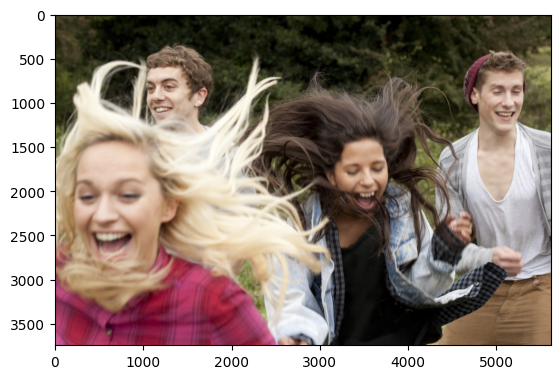

In [115]:
img = cv2.imread('images/happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

- np.expand_dims adds an additional dimesion

In [117]:
yhat = model.predict(np.expand_dims(resize/255, 0)) 

1/1 [==============================] - 0s 29ms/step


In [118]:
yhat

array([[0.10699995]], dtype=float32)

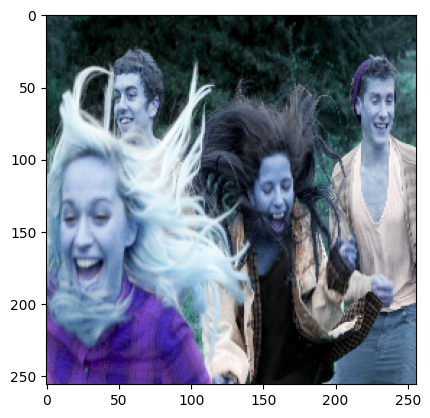

 Predicted class is Happy


In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f' Predicted class is Happy')

# 11. Save the Model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [55]:
new_model = load_model('models\imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 129ms/step


array([[0.00793282]], dtype=float32)